# Message Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Need this to convert datetime objects in matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# TODO: fb messages, text messages, ig messages, call log, whatsapp calls
whatsapp = pd.read_csv('whatsapp_messages.csv')
whatsapp = whatsapp.drop(['UserPhone', 'QuotedMessage', 'QuotedMessageDate', 'QuotedMessageTime'], axis=1)

In [3]:
df = whatsapp
len(df)

6264

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6264 entries, 0 to 6263
Data columns (total 7 columns):
Date1          56 non-null object
Date2          6264 non-null object
Time           6264 non-null object
UserName       6264 non-null object
MessageBody    6264 non-null object
MediaType      76 non-null object
MediaLink      76 non-null object
dtypes: object(7)
memory usage: 342.6+ KB


## Data Cleaning
Let's start the data cleaning up the date/time columns.

First, it looks like in our case all non-null rows of the `Date1` column have the same value as `Date2`, so let's drop `Date1` and rename `Date2`.

In [5]:
date1_neq_date2 = (~df['Date1'].isnull()) & (df['Date1'] != df['Date2'])

print('Number of rows where Date1 is not equal to Date2:', df[date1_neq_date2].shape[0])

Number of rows where Date1 is not equal to Date2: 0


In [6]:
# Consolidate Date1 and Date2
df = df.drop(['Date1'], axis=1)
df = df.rename(columns={'Date2': 'Date'})

In [7]:
# Combine date and time col to get full timestamp
df['Timestamp'] = df['Date'] + ' ' + df['Time']
df = df.drop(['Date', 'Time'], axis=1)

# Convert to date/time objects
datetime_cols = ['Timestamp']
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col])

In [8]:
df

,UserName,MessageBody,MediaType,MediaLink,Timestamp
0,Harrison,Let's do WhatsApp then,NaN,NaN,2019-08-27 17:26:30
1,Harrison,"My dad's a Jersey boy, Italian if you couldn't...",NaN,NaN,2019-08-27 17:27:20
2,Harrison,I was a music major for a year and nearly had ...,NaN,NaN,2019-08-27 17:28:05
3,Harrison,Insects are vegan right? Ever tried one?,NaN,NaN,2019-08-27 17:28:50
4,Jayqwellin Morsay,Cool glad you have WhatsApp! It's the best,NaN,NaN,2019-08-27 18:43:17
5,Jayqwellin Morsay,Gonna take full advantage of the reply feature...,NaN,NaN,2019-08-27 18:44:41
6,Jayqwellin Morsay,I think so? And no ew. You?,NaN,NaN,2019-08-27 18:45:07
7,Jayqwellin Morsay,Does that involve a specific instrument?? Soun...,NaN,NaN,2019-08-27 18:46:03
8,Jayqwellin Morsay,😄 yeah hahaha I could guess. That's cool. Do y...,NaN,NaN,2019-08-27 18:47:12
9,Harrison,Tried something I had no idea what it was in T...,NaN,NaN,2019-08-27 19:33:37


## Analysis

In [9]:
terms_of_endearment = ['amor', 'amour', 'chéri', 'chérie', 'honey', 'liebe', 'love', 'strawberry', 'shortcake', 'sleepy', 'sweety', 'sweetie', '❤️', '😘']
terms_of_laughter = ['lol', 'lmao', 'lmfao', 'haha', '😂', '🤣']

In [10]:
by_date = df.groupby([df['Timestamp'].dt.date])

num_msgs_by_date = by_date.count()['MessageBody']

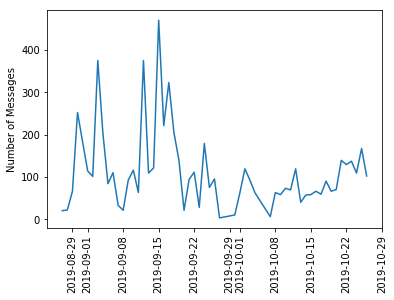

In [14]:
plt.plot(num_msgs_by_date)
plt.ylabel('Number of Messages')
plt.xticks(rotation=90)
plt.show()

In [15]:
# Cumulative messages by date
cumulative_messages = num_msgs_by_date.cumsum()

Timestamp
2019-08-27      20
2019-08-28      42
2019-08-29     108
2019-08-30     360
2019-09-01     474
2019-09-02     575
2019-09-03     950
2019-09-04    1154
2019-09-05    1238
2019-09-06    1348
2019-09-07    1381
2019-09-08    1402
2019-09-09    1494
2019-09-10    1610
2019-09-11    1673
2019-09-12    2048
2019-09-13    2157
2019-09-14    2278
2019-09-15    2748
2019-09-16    2969
2019-09-17    3292
2019-09-18    3497
2019-09-19    3636
2019-09-20    3657
2019-09-21    3751
2019-09-22    3862
2019-09-23    3890
2019-09-24    4069
2019-09-25    4144
2019-09-26    4239
2019-09-27    4242
2019-09-30    4252
2019-10-01    4314
2019-10-02    4433
2019-10-03    4525
2019-10-04    4587
2019-10-07    4593
2019-10-08    4656
2019-10-09    4714
2019-10-10    4787
2019-10-11    4856
2019-10-12    4975
2019-10-13    5015
2019-10-14    5072
2019-10-15    5130
2019-10-16    5196
2019-10-17    5255
2019-10-18    5345
2019-10-19    5411
2019-10-20    5481
2019-10-21    5620
2019-10-22    5749
20

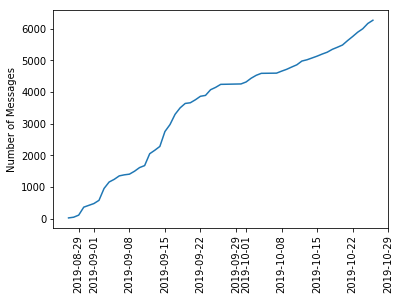

In [16]:
plt.plot(cumulative_messages)
plt.ylabel('Number of Messages')
plt.xticks(rotation=90)
plt.show()